# Workflow to modify `TGF` dataset

## Importing necessary libraries

In [1]:
import xarray as xr # version 2023.2.0
import pandas as pd # version 1.5.3
import numpy as np # version 1.24.2
import geopandas as gpd # version 0.12.2
import networkx as nx # version 3.1

import matplotlib.pyplot as plt # version 3.7.0

import fiona # version 1.9.2

from typing import (
    Dict,
    Tuple,
    Union,
    List,
)

from collections.abc import (
    Callable,
)

### Defining paths and preparing objects

In [2]:
# defining paths
# downloaded from https://www.sciencebase.gov/catalog/item/5d967365e4b0c4f70d113923
tgf_path = '/Users/kasrakeshavarz/Documents/geospatial-data/NHM_TGF/TGF.gdb/'
# obtained from Jamie Kolodinsky (jamie.kolodinsky@ec.gc.ca)
huc12_path = '/Users/kasrakeshavarz/Documents/geospatial-data/StMary-Milk/HUC/HUC12/SMM_HUC12.shp'
# slope values - downloaded from https://www.sciencebase.gov/catalog/item/5efcbb9582ce3fd7e8a5b9ea
slope_path = '/Users/kasrakeshavarz/Documents/geospatial-data/NHM_TGF/tb_params-master/seg_slope.csv'

# list tgf layers
fiona.listlayers(tgf_path)

['POIs', 'waterbodies', 'nhru', 'nsegment']

In [3]:
# read tgf layers
## river segments
tgf_riv = gpd.read_file(tgf_path, driver='FileGDB', layer='nsegment')
## basins
tgf_cat = gpd.read_file(tgf_path, driver='FileGDB', layer='nhru')
## slope of segments
tgf_slope = pd.read_csv(slope_path, index_col=0, header=0)
## HUC12 layer
huc12_cat = gpd.read_file(huc12_path)

In [4]:
# getting list of columns
cols = tgf_riv.columns.to_list()

# adding `tgf_slope` to `tgf_riv`
tgf_riv = pd.concat([tgf_riv.set_index('seg_id_tb', drop=False), tgf_slope], axis=1).reset_index(drop=True)

# reordering columns
new_order = cols[0:-1]+['seg_slope', cols[-1]]
tgf_riv = tgf_riv[new_order]

## Necessary functions

In [5]:
# Checking wether spatial connectivities are valid

def spatial_conn(
    gdf: gpd.GeoDataFrame,
    main_id: str=None,
    ds_main_id: str=None,
    print_err: bool=True,
) -> Tuple[Dict, Dict]:
    
    '''Validates downstream IDs and checks spatial connectivity 
    of river elements
    
    Parameters
    ----------
    gdf: geopandas.GeoDataFrame
        a GeoPandas dataframe containing details of a river network
        with minimum details of element ID, downstream element ID, and
        geometries
    main_id: str, defaults to `None`
        String defining the column of element IDs in the input geopandas
        dataframe
    ds_main_id: str, defaults to `None`
        String defining the column of downstream element IDs in the
        input geopandas dataframe
    print_err: bool, defaults to `True` (optional)
        Argument to specify either print the detailed errors within the
        input `gdf`
        
    Returns
    -------
    connections: Dict
        A dictionary of connections with keys as `main_id` and
        values of `ds_main_id` if no issues were found
    wrong_conns: Dict
        A dictionary of problematic connections with keys as `main_id`
        and values defining the nature of the problem, available error
        types: 1) spatial disconnection (`spdis`), 2) missing downstream
        element (misds)
        
    '''
    
    # necessary initializations
    connections = {} # key: `main_id`, value: `ds_main_id`
    wrong_conns = {} # key: `main_id`, value: error type
    
    
    if main_id is None:
        raise ValueError("`main_id` cannot be `None`")
        
    if ds_main_id is None:
        raise ValueError("`ds_main_id` cannot be `None`")

    # Loop through each feature in the shapefile
    for idx, feature in gdf.iterrows():

        # Skip over features with DS_Main_ID = 0
        if feature[ds_main_id] == 0:
            continue

        # Find the corresponding descendant feature
        descendant = gdf.loc[gdf[main_id] == feature[ds_main_id]]

        # Check if the descendant DataFrame is empty
        if descendant.empty:
            # find possible downstream IDs of 'DS_Main_ID' does not exist
            possible_ds = gdf.geometry.intersects(gdf.loc[idx].geometry)
            possible_ds_list = gdf[possible_ds][main_id].tolist()
            
            # add the `Main_ID` to the `wrong_conns` list
            wrong_conns[feature[main_id]] = 'misds'

            # print details
            if print_err:
                print(f"Warning: No descendant feature found for `main_id`={feature[main_id]} with `ds_main_id`={feature[ds_main_id]}")
                print(f"  Possible downstream IDs are: {possible_ds_list}")

            continue

        # Check if the feature's geometry intersects with the descendant's geometry
        if not feature.geometry.intersects(descendant.geometry.iloc[0]):

            if print_err:
                print(f"Feature with main_id {feature[main_id]} is not spatially connected to its descendant with ds_main_id {feature[ds_main_id]}")
                
            # add the `Main_ID` to the `wrong_conns` dictionary
            wrong_conns[feature[main_id]] = 'spdis'
        else:
            # add the `Main_ID` to the `connections` dictionary
            connections[feature[main_id]] = feature[ds_main_id]
    
    return connections, wrong_conns

In [6]:
def find_cycles(
    gdf: gpd.GeoDataFrame,
    main_id: str,
    ds_main_id: str,
    l: int=None,
    print_err: bool=True,
) -> list[...]:
    '''Returns the cycles of length `l` of a river network given 
    as a geopandas GeoDataFrame
    
    Parameters
    ----------
    gdf: geopandas.GeoDataFrame
        GeoDataFrame of river segments including at least three pieces
        of information: 1) geometries of segments, 2) segment IDs, and
        3) downstream segment IDs
    main_id: str, defaults to `None`
        String defining the column of element IDs in the input geopandas
        dataframe
    ds_main_id: str, defaults to `None`
        String defining the column of downstream element IDs in the
        input geopandas dataframe
    l: int, defaults to None (optional)
        length of cycles to be found, leave as None to find
        cycles of any length
    print_err: bool, defaults to `True` (optional)
        print cycles if stated
    
    Returns
    -------
    cycles: list
        List of `main_id`s indicating cycles
    
    '''
    
    # creating a DiGraph out of `gdf` object
    riv_graph = nx.from_pandas_edgelist(gdf, source=main_id, target=ds_main_id, create_using=nx.DiGraph)

    # extracting cycles
    cycles = list(nx.simple_cycles(riv_graph, l))
    
    if print_err:
        print(cycles)
    
    return cycles

In [7]:
def find_upstream(
    gdf: gpd.GeoDataFrame,
    target_id: Union[str, int, ...],
    main_id: str,
    ds_main_id: str,
) -> set[...]:
    '''Find "ancestors" or upstream segments in a river network given
    in the from of a geopandas.GeoDataFrame `gdf`
    
    Parameters
    ----------
    gdf: geopandas.GeoDataFrame
        GeoDataFrame of river segments including at least three pieces
        of information: 1) geometries of segments, 2) segment IDs, and
        3) downstream segment IDs
    target_id: str, int, or any other data type as included in `gdf`
        Indicating the target ID anscestor or upstream of which is
        desired
    main_id: str
        String defining the column of element IDs in the input geopandas
        dataframe
    ds_main_id: str
        String defining the column of downstream element IDs in the
        input geopandas dataframe
    
    Returns
    -------
    nodes: list
        IDs of nodes being upstream or anscestor of the `target_id`
    
    '''
    # creating a DiGraph out of `gdf` object
    riv_graph = nx.from_pandas_edgelist(gdf, source=main_id, target=ds_main_id, create_using=nx.DiGraph)
    
    # return nodes in a list
    nodes = nx.ancestors(riv_graph, target_id)
    
    return nodes

In [8]:
ID_type = Union[int, str, ...]

def union_seg(
    gdf: gpd.GeoDataFrame,
    by: str,
    id_dict: Dict[List[ID_type], ID_type],
    agg_dict: Dict[str, Callable] = None,
) -> gpd.GeoDataFrame:
    '''Return modified `gdf` after substituting `ids` with their union
    and applying `aggfunc`'s functions to their attributes
    
    Parameters
    ----------
    gdf: geopandas.GeoDataFrame
        GeoDataFrame containing various geometries with at least one attribute
    by: str
        Attribute name of the `gdf` for which `ids` are given
    id_dict: dict
        A dictionary with keys of list of IDs of elements the union
        of which is needed and values of the corresponding ID of the
        element for which the union is reported for      
    agg_dict: Dict
        A dictionary consisting of keys corresponding to the attributes
        of `gdf` and values corresponding to a function to be applied
        to the attribute values of `ids`
        
    Returns
    -------
    modified_gdf: geopandas.GeoDataFrame
        Modified GeoDataFrame where the union of `ids` replaces the
        `ids` themselves. 
    '''
    
    # getting list of columns from `gdf`
    cols = gdf.columns.tolist() # getting list of columns
    # removing column names that have specific aggregation 
    # method(s) defined for them in the `agg_dict`
    for i in agg_dict.keys(): # removing those having specific aggregation methods
        cols.remove(i)
    # also removing `geometry` column from `gdf` since it is a
    # geopandas.GeoDataFrame object
    cols.remove('geometry')
    
    # iterate over id_dict elements, `id_list` is a tuple
    for id_list, target in id_dict.items():
        
        # extracting `ids` from `gdf`
        selected_gdf = gdf.loc[gdf[by].isin(id_list), :].copy()

        # union of `ids`
        union = selected_gdf.unary_union

        # implementing aggregations defined for each column in `agg_dict`;
        # first, preparing the `agg_gdf`
        agg_gdf = selected_gdf.drop(columns='geometry') # gpd.GeoDataFrame to pd.DataFrame
        agg_gdf.set_index(keys=[by], drop=True, inplace=True) # setting index to `by`

        # defining a lambda function which returns "target" (`t`) values
        # for a given "column" (`x`) if it is in the list of columns
        # defined above `cols` or `c` here; note that `c` contains column
        # names that have not been defnined in the `agg_dict`
        f = lambda x, t, c: x.loc[t] if x.name in c else agg_dict[x.name](x)
        
        # implementing aggregations
        agg_gdf = agg_gdf.agg(func=f, t=target, c=cols)
        
        # making a geopandas.GeoDataFrame out of created geometry in `union`
        # as it is needed for the concatenation step below
        agg_gdf_geom = gpd.GeoDataFrame(agg_gdf.to_frame().T, geometry=gpd.GeoSeries(union))
        # the `by` itself was set as an index, so the value is assigned here
        agg_gdf_geom[by] = target
        # set the .crs of `agg_gdf_geom` same as gdf
        agg_gdf_geom.set_crs(gdf.crs, inplace=True)
        
        # removing `id_list` from gdf (`rem_gdf`), concatenating `agg_gdf_geom`,
        # and returning `modified_gdf`
        gdf.drop(gdf.index[gdf[seg_str].isin(id_list)], inplace=True)
        gdf = gpd.GeoDataFrame(pd.concat([gdf, agg_gdf_geom]))
        
    return gdf

In [9]:
def sanitize_connectivity(
    gdf: gpd.GeoDataFrame,
    main_id: str,
    ds_main_id: str,
    id_dict: Dict[List[ID_type], ID_type],
) -> gpd.GeoDataFrame:
    '''Corrects river network connectivity after union aggregations
    implemented on a few segments. Modified GeoDataFrame where the
    segments with end to elements in `id_list` that are not `target`
    have now a `ds_main_id` of `target`
    
    Parameters
    ----------
    gdf: geopandas.GeoDataFrame
        GeoDataFrame of river segments including at least three pieces
        of information: 1) geometries of segments, 2) segment IDs, and
        3) downstream segment IDs
    main_id: str
        String defining the column of element IDs in the input geopandas
        dataframe
    ds_main_id: str
        String defining the column of downstream element IDs in the
        input geopandas dataframe
    id_dict: dict
        A dictionary with keys of list of IDs of elements the union
        of which was added and values of the corresponding ID of the
        element for which the union was reported for  
    
    Returns
    -------
    modified_gdf: geopandas.GeoDataFrame
        Modified GeoDataFrame where the segments with end to elements in `id_list`
        that are not `target` have now a `ds_main_id` of `target`
    '''
    
    modified_gdf = gdf
    
    # loop over elements of `id_dict`
    for id_list, target in id_dict.items():
    
        # correcting ids in the `id_list`
        for segment in id_list:
            # skip if it is the target itself
            if segment == target:
                continue
            # change the downstream value to `target
            else:
                modified_gdf.loc[modified_gdf[ds_main_id] == segment, ds_main_id] = target
    # reseting index
    modified_gdf.reset_index(drop=True, inplace=True)
    
    return modified_gdf

## Necessary assumptions

In [10]:
seg_str = 'seg_id_nhm'
ds_seg_str = 'tosegment_nhm'
cat_str = 'hru_segment_nhm'

## Modifying river segments

### Checking river segments

#### Downcasting datatypes as necessary

First a datatype downcasting on the values of segment IDs and hru IDs are done:

In [11]:
# safe copy of `tgf_riv` for further analysis
riv = tgf_riv.copy()

# safe copy of `tgf_cat` for further analysis
cat = tgf_cat.copy()

In [12]:
# list of columns to be chosen for dtype downcast
col_list = [seg_str, ds_seg_str]

# downcast dtype of necessary columns to integer, if possible
fcols = riv[col_list].select_dtypes('float').columns
riv[fcols] = riv[fcols].apply(pd.to_numeric, downcast='integer')

In [13]:
# checking if downcasting is done right
for col in col_list:
    print(f'Downcasting for the dtype of column `{col}` is right: ', (tgf_riv[col] == riv[col]).astype(int).sum() == tgf_riv.shape[0])

Downcasting for the dtype of column `seg_id_nhm` is right:  True
Downcasting for the dtype of column `tosegment_nhm` is right:  True


#### Check upstream/downstream connectivity

In [14]:
conns, err_conns = spatial_conn(riv, seg_str, ds_seg_str, True)

Feature with main_id 57086 is not spatially connected to its descendant with ds_main_id 57194
Feature with main_id 57143 is not spatially connected to its descendant with ds_main_id 57133
Feature with main_id 57495 is not spatially connected to its descendant with ds_main_id 57380
Feature with main_id 58015 is not spatially connected to its descendant with ds_main_id 57926
Feature with main_id 58046 is not spatially connected to its descendant with ds_main_id 58067
Feature with main_id 58049 is not spatially connected to its descendant with ds_main_id 58067
  Possible downstream IDs are: [58662, 58663, 58793, 58876]
  Possible downstream IDs are: [58662, 58876]
Feature with main_id 58877 is not spatially connected to its descendant with ds_main_id 60076
Feature with main_id 59160 is not spatially connected to its descendant with ds_main_id 58891
Feature with main_id 59719 is not spatially connected to its descendant with ds_main_id 58889
Feature with main_id 59956 is not spatially conn

#### Checking existing cycles

River networks could be considered a special case of directed acyclic graphs (DAGs), therefore, for verification purposes of this Notebook, we could use algorithms designed for this specific type of graphs. `NetworkX` usually has necessary functions for graph analysis!

In [15]:
cycles = find_cycles(riv, seg_str, ds_seg_str)

[]


Iteratively, the cycles are corrected manually. I cannot think of any automated way to correct the cycles. Feel free to let me know if you are aware of any!

In [16]:
# Iteration 1
# cycles found are corrected by assigning the right downstream IDs inspected visually
# this code only exists as a template for future references

cycles_corr = {
}

for us, ds in cycles_corr.items():
    riv.loc[riv[seg_str] == us, ds_seg_str] = ds
    
cycles = find_cycles(riv, seg_str, ds_seg_str)

[]


### Fixing irregular river segment IDs

#### Invalid downstream IDs

Visually, valid IDs are evaluated and assigned to those reported above. If the downstream/upstream element connectivity details are correct, but spatial disconnectivity is observed, no correction is needed as data are fed into routing models for hydrology, and spatial connectivity does not matter.

Since the `seg_id_nhm` has been chosen as the main ID of river segments, some downstream values need to be adjusted. This is **NOT** a problem with the river segments of `TGF`, but a minor adjustment for GWF modelling wokrflows to be compatible with the transboundary region, if needed. The values are still valid if the bigger `GFv1.1` is being considered as the geofabric for modelling is it covers areas not included in `TGF`.

In [17]:
# for the segment ID of `err_conns`, the correct downstream IDs are assigned
misds_corr = {
    58662: 0,
    58876: 0,
    59972: 0,
}

for us, ds in misds_corr.items():
    riv.loc[riv[seg_str] == us, ds_seg_str] = ds

In [18]:
conns, err_conns = spatial_conn(riv, seg_str, ds_seg_str, True)

Feature with main_id 57086 is not spatially connected to its descendant with ds_main_id 57194
Feature with main_id 57143 is not spatially connected to its descendant with ds_main_id 57133
Feature with main_id 57495 is not spatially connected to its descendant with ds_main_id 57380
Feature with main_id 58015 is not spatially connected to its descendant with ds_main_id 57926
Feature with main_id 58046 is not spatially connected to its descendant with ds_main_id 58067
Feature with main_id 58049 is not spatially connected to its descendant with ds_main_id 58067
Feature with main_id 58877 is not spatially connected to its descendant with ds_main_id 60076
Feature with main_id 59160 is not spatially connected to its descendant with ds_main_id 58891
Feature with main_id 59719 is not spatially connected to its descendant with ds_main_id 58889
Feature with main_id 59956 is not spatially connected to its descendant with ds_main_id 59686
Feature with main_id 60020 is not spatially connected to its

In the above message, we see there are a few segments that are not spatially connected to their downstream segments. Either the LineString is not built properly, or the downstream ID is wrong. However, since the above segments are outside of the `SMM` area, we refrain from fixing these for the time being. 

#### Correcting river segments without a corresponding sub-basin ID

In [19]:
# find river segment that are not associated with any sub-basin 
riv.loc[~riv[seg_str].isin(cat[cat_str]), seg_str]

414     56880
514     56980
1063    57536
1962    58443
4055    60539
5102    61595
5398    61891
Name: seg_id_nhm, dtype: int64

Upon visual investigation, it was found that there are a few segments that are separated by a `POI`, and that is the reason some river segments are not associated with any sub-basins (or hrus). This is **NOT** a problem with `TGF` as POIs are providing more information. However, they can cause issues for `GWF` modelling workflows, hence are corrected here:

In [20]:
#### gdf = riv
idd = {
    (56980, 56910): 56910,
    (58443, 58440): 58440,
    (61595, 62268): 62268,
    (61891, 62267): 62267,
}
aggd = {
    'Shape_Length':np.sum,
    'seg_slope':np.mean, # simplifying assumption
}

riv = union_seg(riv, seg_str, idd, aggd)
riv = sanitize_connectivity(riv, seg_str, ds_seg_str, idd)

In [21]:
# rearrange columns
riv_columns = [seg_str, ds_seg_str] + riv.columns.to_list()
riv_columns = unique_list = [x for i, x in enumerate(riv_columns) if x not in riv_columns[:i]] # remove repetition
riv = riv[riv_columns]

## Modifying sub-basins

### Assigning sub-basins to river segments without one

In [22]:
# find river segment that are not associated with any sub-basin
# checking again:
riv.loc[~riv[seg_str].isin(cat[cat_str]), seg_str]

414     56880
1061    57536
4051    60539
Name: seg_id_nhm, dtype: int64

In [23]:
# two river ids do not have any sub-basins assigned to them;
# upon visual inspection, the most logical sub-basin has been
# assigned to them. These three segments are part of a lake
# system
cat_riv_dict = {
    # hru : segment
    112231: 57536,
    118646: 60539,
}

# river segment 56880 is remained without a sub-basin as
# sub-basin 110936 needs to be `exploded` and the part
# associated with segment `56880` need to be set separately

for cat_id, seg_id in cat_riv_dict.items():
    cat.loc[cat['hru_id_nhm'] == cat_id, 'hru_segment_nhm'] = seg_id

In [24]:
# find river segment that are not associated with any sub-basin
# checking again:
riv.loc[~riv[seg_str].isin(cat[cat_str]), seg_str]

414    56880
Name: seg_id_nhm, dtype: int64

### Dissolving left-/right-banks of sub-basins

For `dissolving` the sub-basins with identical IDs, the `hru_segment_nhm` attribute has been chosen as the identifier. It should be noted that, if the sub-basin is not associated with any river segment, the value of `hru_segment_nhm` is defined as `0`.

Furthermore, it was initially thought that for each river segment, 2 corresponding sub-basins, left-bank and right-bank ones, exist. However, with further exploration of the `TGF` dataset, it was concluded that this number varies between 1 and 5.

Since there is no automated way of correcting these issues, we only dissolve sub-basins based on the `hru_segment_nhm` values. Further corrections could be manually implemented, however, we avoid doing so for this project.

In [25]:
# removing sub-basins without a river segment for now
filtered_cat = cat[cat[cat_str] != 0]

# dissolving remaining sub-basins by their hru_segment_nhm
## making aggregation function
aggf = {
    'Shape_Area':np.sum,
    'Shape_Length':np.mean,
}
# assigning aggregation methods to each column of `cat`
for col in filtered_cat.columns:
    if col not in aggf.keys() and col!='geometry' and col!='hru_segment_nhm':
        aggf[col] = 'first'
# dissolving left and right banks
dissolved_filt_cat = filtered_cat.dissolve(by=cat_str, aggfunc=aggf, as_index=False)

# adding back sub-basins without river segments
zero_values_gdf = cat[cat[cat_str] == 0]

# concatenating polygons with zero 'hru_segment' values to the dissolved GeoDataFrame
dissolved_cat = gpd.GeoDataFrame(pd.concat([dissolved_filt_cat, zero_values_gdf]))

# reordering columns
cat_columns = ['hru_id_nhm'] + ['hru_segment_nhm'] + cat.columns.to_list() # making a list of columns
cat_columns = unique_list = [x for i, x in enumerate(cat_columns) if x not in cat_columns[:i]] # remove repetition
dissolved_cat = dissolved_cat[cat_columns]

### Correcting sub-basins (non-coastal and non-NCA) without a corresponding river segment

In [26]:
# check if sub-basins (that are not NCA or coastal) have a river segment associated with them
dissolved_filt_cat[~dissolved_filt_cat[cat_str].isin(riv[seg_str])]

,hru_segment_nhm,geometry,Shape_Area,Shape_Length,POI_ID,hru_id,hru_segment,hru_id_tb,hru_segment_tb,hru_id_nhm,Type_NCA,HUC04,Coastal_HRU


## Extracting river segments of the `SMM` area based on upstream/downstream connectivity

Based on the boundary of the HUC12 dataset shared by [Jamie Kolodinsky](jamie.kolodinsky@ec.gc.ca), for the St. Mary portion, the most downstream river segment is `58183`, and for the Milk portion is `58242`.

In [27]:
# empty dictionary for extracting ancestor nodes
nodes = {}

# dictionary of target ids
target_ids = {
    'st_mary': 58183,
    'milk': 58242,
}

# extracting ancestors
for river, target in target_ids.items():
    # extracting ancestors
    ancestors = find_upstream(riv, target, seg_str, ds_seg_str)
    # adding target node to the `ancestors` set
    ancestors.add(target)
    # adding to the ancestor dictionary
    nodes[river] = ancestors

## Extracting river segments based on spatial overlap with the pre-defined boundary

Based on the boundary of the HUC12 dataset shared by [Jamie Kolodinsky](jamie.kolodinsky@ec.gc.ca), an overlap check is done to cover sub-basins that are within the boundary, but are not contributing the main river systems.

In [28]:
smm_boundary = huc12_cat.to_crs(riv.crs).dissolve()

Now, we extract basins that are contributing and non-contributing overlaying with the boundary layer. We will further refine this GeoDataFrame based on `nodes`:

In [29]:
# selecting those intersecting with the boundary layer with a buffer of 6km
overlay_smm_cat = dissolved_cat[dissolved_cat.intersects(smm_boundary.buffer(-6e3).geometry.iloc[0])]

Then, we select river segments extracted based on up-/downstream connectivity, select their sub-basins, add those basins that are not connected to the main streams but are still inside the boundary of `SMM`:

In [30]:
# creating a set of all SMM river segments
smm_riv_nodes = nodes['st_mary'].union(nodes['milk'])

# getting id of river segments of the `overlay_smm_cat` 
overlay_smm_nodes = overlay_smm_cat.loc[overlay_smm_cat['hru_segment_nhm'] != 0, 'hru_segment_nhm']

# updating the `smm_riv_node` set with overlay values
smm_riv_nodes.update(overlay_smm_nodes)

Once, `smm_riv_nodes` is finalized, we will extract `smm_riv` and `smm_cat` files:

In [31]:
# river obejct
smm_riv = riv.loc[riv[seg_str].isin(smm_riv_nodes)].copy()

# sub-basin object
cat_nodes = set(overlay_smm_cat['hru_id_nhm']) # take river segment set
cat_nodes.update(dissolved_cat.loc[dissolved_cat[cat_str].isin(smm_riv_nodes), 'hru_id_nhm']) # add NCA ones
smm_cat = dissolved_cat.loc[dissolved_cat['hru_id_nhm'].isin(cat_nodes)].copy() # copy

Changing the `ds_main_id` value for the outlet river segments:

In [32]:
for _, outlet in target_ids.items():
    smm_riv.loc[smm_riv[seg_str] == outlet, ds_seg_str] = 0

<Axes: >

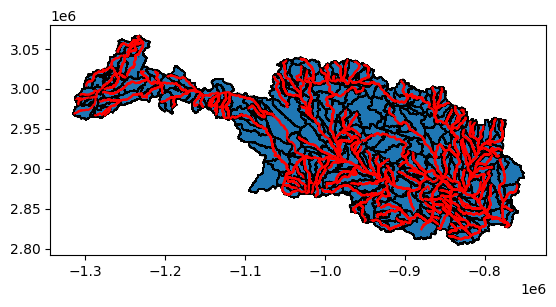

In [33]:
# plotting
fig2, ax2 = plt.subplots(1,1)

smm_riv.plot(ax=ax2, color='red') # rivers
smm_cat.plot(ax=ax2, edgecolor='black') # sub-basins
smm_boundary.plot(ax=ax2, alpha=0.5, color='black')

## Final verifications

### checking connectivity

In [34]:
conns, err_conns = spatial_conn(smm_riv, seg_str, ds_seg_str, True)

### checking cycles

In [35]:
cycles = find_cycles(smm_riv, seg_str, ds_seg_str)

[]


# Saving modified `TGF` dataset

In [36]:
# renaming certain columns to make them less than 10 character
smm_riv.rename(columns={'seg_id_nhm':'seg_nhm', 'tosegment_nhm':'ds_seg_nhm'}, inplace=True)
smm_cat.rename(columns={'hru_segment_nhm':'seg_nhm', 'hru_id_nhm':'hru_nhm'}, inplace=True)

In [37]:
# making WSG84 projection out of the Shapefiles
smm_cat.to_crs(epsg=4326, inplace=True)
smm_riv.to_crs(epsg=4326, inplace=True)

In [39]:
# rivers
smm_riv.to_file('./smm_tgf_modified/smm_riv.shp')
# subbasins
smm_cat.to_file('./smm_tgf_modified/smm_cat.shp')

/var/folders/rw/ngg2x10x2s139yr4lchhykz40000gn/T/ipykernel_45717/2058460126.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  smm_riv.to_file('./smm_tgf_modified/smm_riv.shp')
/var/folders/rw/ngg2x10x2s139yr4lchhykz40000gn/T/ipykernel_45717/2058460126.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  smm_cat.to_file('./smm_tgf_modified/smm_cat.shp')
